<a href="https://colab.research.google.com/github/rattrexch/Intro-to-AI-Group-Project/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install datasets scikit-learn matplotlib pandas numpy

import os, json, math, itertools, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, roc_curve, precision_recall_curve, auc, accuracy_score)

os.makedirs("outputs", exist_ok=True)
SEED = 42

In [ ]:
ds = load_dataset("imdb")
train_df = pd.DataFrame(ds["train"])
test_df  = pd.DataFrame(ds["test"])

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=SEED, stratify=train_df["label"])

for name, df in [("train", train_df), ("val", val_df), ("test", test_df)]:
    print(name, df.shape, "pos =", (df.label==1).mean().round(3))

train_df.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train (20000, 2) pos = 0.5
val (5000, 2) pos = 0.5
test (25000, 2) pos = 0.5


,text,label
20022,I have always been a huge James Bond fanatic! ...,1
4993,I am a Christian and I say this movie had terr...,0
24760,"Neatly sandwiched between THE STRANGER, a smal...",1
13775,Years ago I did follow a soap on TV. So I was ...,1
20504,"Here's a gritty, get-the-bad guys revenge stor...",1


In [ ]:
def savefig(path):
    plt.tight_layout()
    plt.savefig(path, dpi=150, bbox_inches="tight")
    plt.close()

def plot_confusion(y_true, y_pred, labels=("neg","pos"), title="", path=None, normalize=None):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1], normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(xticks_rotation=0, colorbar=False)
    plt.title(title)
    if path: savefig(path)

def binary_curves(y_true, y_score, prefix):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve")
    plt.legend(loc="lower right")
    savefig(f"outputs/{prefix}_roc.png")

    pr, re, _ = precision_recall_curve(y_true, y_score)
    pr_auc = auc(re, pr)
    plt.figure()
    plt.plot(re, pr, label=f"AP={pr_auc:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall Curve")
    plt.legend(loc="lower left")
    savefig(f"outputs/{prefix}_pr.png")

    return {"roc_auc": roc_auc, "pr_auc": pr_auc}

In [ ]:
tfidf_logreg = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,1), min_df=2, max_df=0.9)),
    ("clf",   LogisticRegression(max_iter=1000, solver="liblinear", random_state=SEED))
])

tfidf_logreg.fit(train_df.text, train_df.label)
val_pred = tfidf_logreg.predict(val_df.text)
print(classification_report(val_df.label, val_pred, target_names=["neg","pos"]))

plot_confusion(val_df.label, val_pred, title="LogReg (val) — CM (counts)",
               path="outputs/logreg_val_cm_counts.png")
plot_confusion(val_df.label, val_pred, title="LogReg (val) — CM (row-norm)",
               path="outputs/logreg_val_cm_norm.png", normalize="true")

val_proba = tfidf_logreg.predict_proba(val_df.text)[:,1]
curve_scores = binary_curves(val_df.label, val_proba, prefix="logreg_val")

metrics = {
    "model":"TFIDF+LogReg (baseline)",
    "val_accuracy": accuracy_score(val_df.label, val_pred),
    **curve_scores
}
pd.DataFrame([metrics]).to_csv("outputs/metrics_val.csv", index=False)
metrics

              precision    recall  f1-score   support

         neg       0.90      0.88      0.89      2500
         pos       0.88      0.90      0.89      2500

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



{'model': 'TFIDF+LogReg (baseline)',
 'val_accuracy': 0.8872,
 'roc_auc': np.float64(0.9561409599999999),
 'pr_auc': np.float64(0.9577922452547383)}

In [ ]:
param_grid = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [2,5],
    "clf__C": [0.25, 1.0, 4.0],
    "clf__penalty": ["l2"]
}
grid = GridSearchCV(tfidf_logreg, param_grid, cv=3, n_jobs=-1, scoring="f1")
grid.fit(train_df.text, train_df.label)
print("Best params:", grid.best_params_)
best = grid.best_estimator_

val_pred = best.predict(val_df.text)
print(classification_report(val_df.label, val_pred, target_names=["neg","pos"]))
val_proba = best.predict_proba(val_df.text)[:,1]
curve_scores = binary_curves(val_df.label, val_proba, prefix="logreg_tuned_val")

row = {
    "model":"TFIDF+LogReg (tuned)",
    "val_accuracy": accuracy_score(val_df.label, val_pred),
    **curve_scores
}
pd.concat([pd.read_csv("outputs/metrics_val.csv"), pd.DataFrame([row])]).to_csv("outputs/metrics_val.csv", index=False)

joblib.dump(best, "outputs/model_logreg_tuned.pkl")

Best params: {'clf__C': 4.0, 'clf__penalty': 'l2', 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 2)}
              precision    recall  f1-score   support

         neg       0.91      0.90      0.90      2500
         pos       0.90      0.91      0.90      2500

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



['outputs/model_logreg_tuned.pkl']

In [ ]:
benchmarks = []

svm = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.9)),
    ("clf", LinearSVC())
]).fit(train_df.text, train_df.label)
svm_pred = svm.predict(val_df.text)
benchmarks.append(("TFIDF+LinearSVC", accuracy_score(val_df.label, svm_pred),
                   classification_report(val_df.label, svm_pred, target_names=["neg","pos"], output_dict=True)))
joblib.dump(svm, "outputs/model_svm.pkl")

nb = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.9)),
    ("clf", MultinomialNB())
]).fit(train_df.text, train_df.label)
nb_pred = nb.predict(val_df.text)
benchmarks.append(("TFIDF+MultinomialNB", accuracy_score(val_df.label, nb_pred),
                   classification_report(val_df.label, nb_pred, target_names=["neg","pos"], output_dict=True)))
joblib.dump(nb, "outputs/model_nb.pkl")

rows = []
for name, acc, rep in benchmarks:
    rows.append({"model":name,
                 "val_accuracy":acc,
                 "val_precision_weighted":rep["weighted avg"]["precision"],
                 "val_recall_weighted":rep["weighted avg"]["recall"],
                 "val_f1_weighted":rep["weighted avg"]["f1-score"]})
bench_df = pd.DataFrame(rows)
bench_df.to_csv("outputs/benchmarks_val.csv", index=False)
bench_df

,model,val_accuracy,val_precision_weighted,val_recall_weighted,val_f1_weighted
0,TFIDF+LinearSVC,0.9076,0.907638,0.9076,0.907598
1,TFIDF+MultinomialNB,0.8798,0.880326,0.8798,0.879758


In [ ]:
full_train = pd.concat([train_df, val_df], ignore_index=True)

final = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.9)),
    ("clf",   LogisticRegression(C=grid.best_params_.get("clf__C", 1.0),
                                 penalty="l2", max_iter=1000, solver="liblinear", random_state=SEED))
]).fit(full_train.text, full_train.label)

test_pred  = final.predict(test_df.text)
test_proba = final.predict_proba(test_df.text)[:,1]

print(classification_report(test_df.label, test_pred, target_names=["neg","pos"]))
plot_confusion(test_df.label, test_pred, title="Final (test) — CM (counts)",
               path="outputs/final_test_cm_counts.png")
plot_confusion(test_df.label, test_pred, title="Final (test) — CM (row-norm)",
               path="outputs/final_test_cm_norm.png", normalize="true")
curves = binary_curves(test_df.label, test_proba, prefix="final_test")

summary = {
    "model":"TFIDF+LogReg (final)",
    "test_accuracy": accuracy_score(test_df.label, test_pred),
    **curves
}
pd.DataFrame([summary]).to_csv("outputs/metrics_test.csv", index=False)

joblib.dump(final, "outputs/model_final.pkl")
json.dump(summary, open("outputs/summary.json","w"), indent=2)
summary

              precision    recall  f1-score   support

         neg       0.90      0.90      0.90     12500
         pos       0.90      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



{'model': 'TFIDF+LogReg (final)',
 'test_accuracy': 0.90184,
 'roc_auc': np.float64(0.9644321344),
 'pr_auc': np.float64(0.962723912603448)}

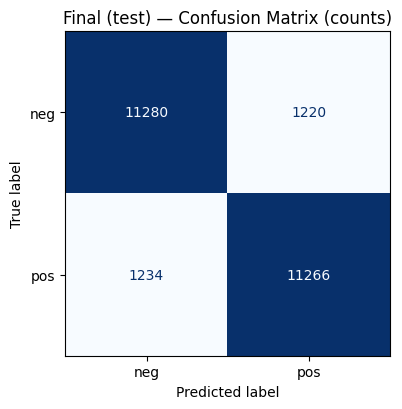

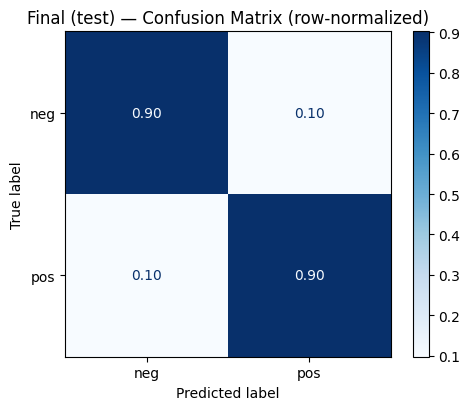

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os

os.makedirs("outputs", exist_ok=True)

test_pred = final.predict(test_df.text)

fig, ax = plt.subplots(figsize=(5.0, 4.2))
cm = confusion_matrix(test_df.label, test_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(values_format="d", cmap="Blues", ax=ax, colorbar=False)
plt.title("Final (test) — Confusion Matrix (counts)")
plt.tight_layout()
plt.savefig("outputs/final_test_cm_counts.png", dpi=150, bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(figsize=(5.2, 4.2))
cm_norm = confusion_matrix(test_df.label, test_pred, labels=[0, 1], normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=["neg", "pos"])
disp.plot(values_format=".2f", cmap="Blues", ax=ax, colorbar=True)
plt.title("Final (test) — Confusion Matrix (row-normalized)")
plt.tight_layout()
plt.savefig("outputs/final_test_cm_norm.png", dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
def predict_review(text):
    proba = final.predict_proba([text])[0,1]
    label = "positive" if proba>=0.5 else "negative"
    return {"label": label, "probability": float(proba)}
print(predict_review("A heartfelt, beautifully acted movie."))
print(predict_review("This was painfully boring and way too long."))

{'label': 'positive', 'probability': 0.7882237861344629}
{'label': 'negative', 'probability': 0.0069002228813363885}


In [ ]:
# This demo pulls real IMDB test reviews and showcases how the model works, making it interactive and it also has a labelled example which you can determine for yourself if it is positive or negative.
def demo_on_test(n=3, max_chars=350):
    samp = test_df.sample(n=n, random_state=SEED)
    probs = final.predict_proba(samp.text)[:, 1]
    preds = (probs >= 0.5).astype(int)
    for (text, y_true, p, y_hat) in zip(samp.text, samp.label, probs, preds):
        true_label = "positive" if y_true == 1 else "negative"
        pred_label = "positive" if y_hat == 1 else "negative"
        print("-" * 80)
        print(f"True: {true_label} | Pred: {pred_label} | Prob(pos): {p:.3f}")
        snippet = text.replace("\n", " ")
        print(snippet[:max_chars] + ("..." if len(snippet) > max_chars else ""))

demo_on_test(n=3)

--------------------------------------------------------------------------------
True: negative | Pred: negative | Prob(pos): 0.052
I could not believe how terrible and boring this Hollywood remake was.It's so dreadful. It easily lands a place in my top 10 worst films of 1998.About the only thing it had going for it was Bruce Willis,who should stick to action films,as a completely emotionless killer who'd kill his own mother for the right price.But I'd rather listen to Robbie C...
--------------------------------------------------------------------------------
True: positive | Pred: positive | Prob(pos): 0.811
I rented Boogie Nights last week and I could tell you, when I watched the film I had a blast. If you think that when you watch the film you will get sicked by the porn. I mean yes, if your not a porn person who can't bother being by it, than this isn't the film to see. But the thing is, the whole film isn't really about porn. Well halfway through t...
----------------------------